In [157]:
%matplotlib inline

import qiskit
qiskit.__qiskit_version__
from qiskit import *

from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

from qiskit.providers.ibmq import least_busy

from numpy import *

# IBMQ Account configuration and Base definitions

In [158]:
#IBMQ.save_account('you_account_token', overwrite=False)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

ibmqfactory.load_account:WARNING:2023-04-12 19:40:19,510: Credentials are already in use. The existing account in the session will be replaced.


Stabilizer configuration
[[n,k,d]] = [[3,1,3]]

In [159]:
nb_n = int(3)
nb_k = int(1)
nb_d = int(3)
nb_m = nb_n - nb_k
print(f"[[n,k,d]] = [[{nb_n},{nb_k},{nb_d}]]")
print(f"m = {nb_m}")

[[n,k,d]] = [[3,1,3]]
m = 2


# Define the Quantum Circuit for bit-flip syndromes
Circuit definition is composed by: Logical Qubit + Ancilla Qubit for stabilizer code).
The example counts 1 logical qubits with 1 data qubit and 2 replication qubits

## Define circuit meta-data

In [160]:
class LogicalCircuitDefinition:
    def __init__(self, n, m):
        self._n = n
        self._m = m

        self.logical_qu = QuantumRegister(n)
        self.ancilla_qu = AncillaRegister(m)
        self.classical_bits = ClassicalRegister(n)

        self.q_circuit = QuantumCircuit(self.logical_qu, self.ancilla_qu, self.classical_bits)

        # Put all qubits into ground state
        for j in range(n):
            self.q_circuit.reset(self.logical_qu[j])
        for j in range(m):
            self.q_circuit.reset(self.ancilla_qu[j])

def CountQiskitStates(circuitDetails):
    circuitDetails.q_circuit.measure(circuitDetails.logical_qu, circuitDetails.classical_bits)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuitDetails.q_circuit, backend=simulator).result()

    return result.get_counts(circuitDetails.q_circuit)

def IntroduceBitFlipError(circuitDetails, n):
    circuitDetails.q_circuit.x(circuitDetails.logical_qu[n])

def CreateSingleQubitQuantumCircuit(n, m):
    circuitDetails = LogicalCircuitDefinition(n, m)

    # Randomly create a superposition state for the data qubit
    circuitDetails.q_circuit.ry( pi/7, circuitDetails.logical_qu[0] )
    # Entagle the data qubit with the replication qubits
    for j in range(1, n):
        circuitDetails.q_circuit.cx(circuitDetails.logical_qu[j-1], circuitDetails.logical_qu[j])

    return circuitDetails


### Display single monitor circuit for bit-flip error
Simulates a bit-flip error by applying an Z-gate on qubit-2

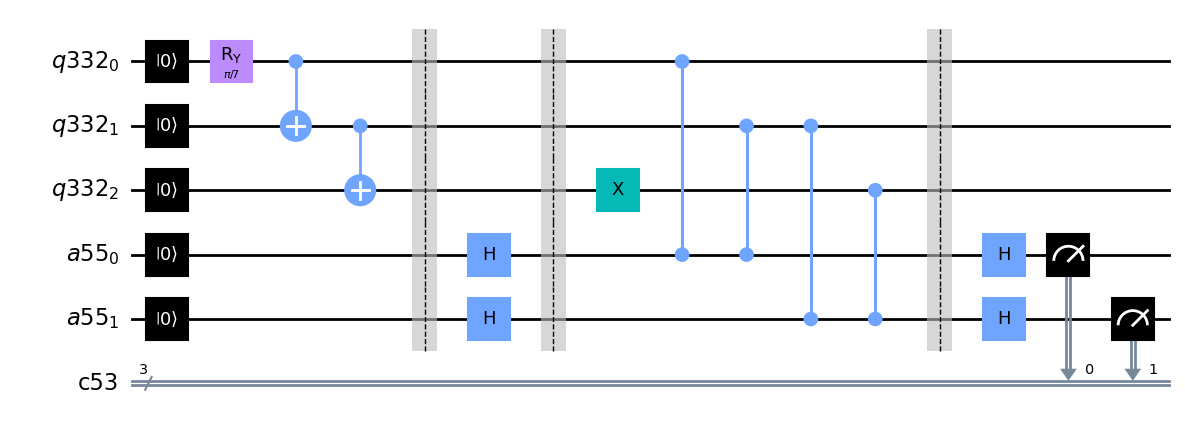

In [161]:
circuitDef = CreateSingleQubitQuantumCircuit(nb_n, nb_m)

circuitDef.q_circuit.barrier()
# Hadmard all Ancillas...
for n in range(nb_m):
    circuitDef.q_circuit.h(circuitDef.ancilla_qu[n])
circuitDef.q_circuit.barrier()

# Introduces a bit-flip in Qubit-2
IntroduceBitFlipError(circuitDef, 2)

# Syndrome gate operations (CZ-gate)
circuitDef.q_circuit.cz([0,1], circuitDef.ancilla_qu[0])
circuitDef.q_circuit.cz([1,2], circuitDef.ancilla_qu[1])
circuitDef.q_circuit.barrier()

for n in range(nb_m):
    circuitDef.q_circuit.h(circuitDef.ancilla_qu[n])

circuitDef.q_circuit.measure(circuitDef.ancilla_qu[0], circuitDef.classical_bits[0])
circuitDef.q_circuit.measure(circuitDef.ancilla_qu[1], circuitDef.classical_bits[1])

circuitDef.q_circuit.draw(output='mpl')

State distribution for the logical bits

Calculate error syndrome

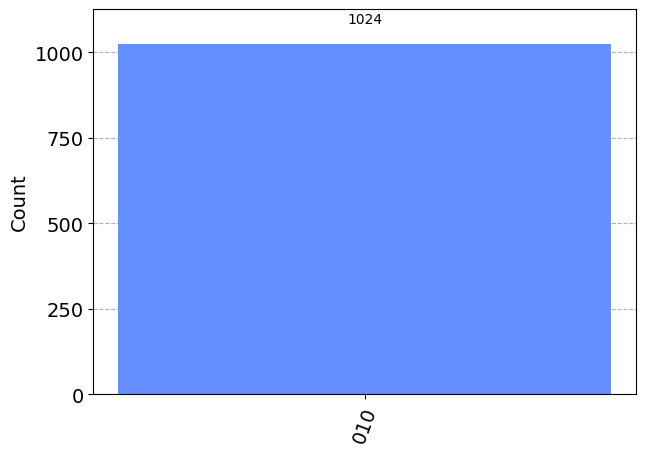

In [162]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuitDef.q_circuit, backend=simulator, shots=1024).result()
plot_histogram(result.get_counts(circuitDef.q_circuit))

In [163]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(circuitDef.q_circuit, backend)).result()
psi  = result.get_statevector(circuitDef.q_circuit)

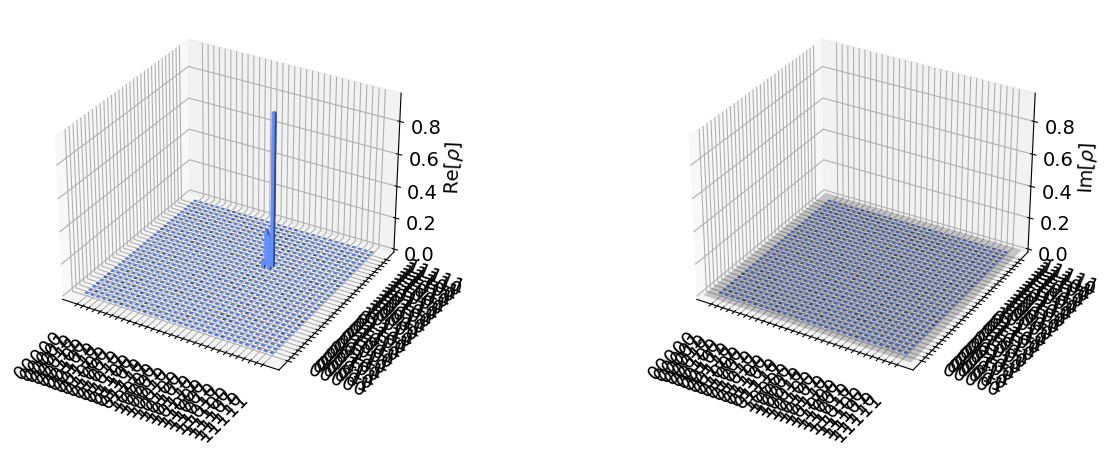

In [164]:
plot_state_city(psi)

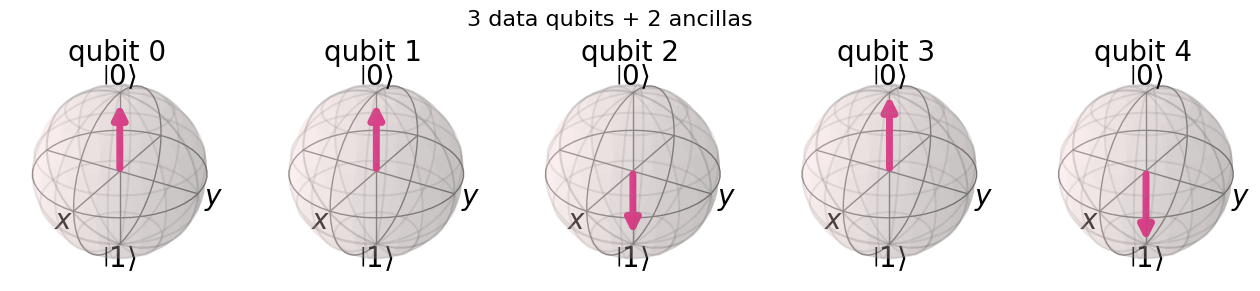

In [165]:
plot_bloch_multivector(psi, title="3 data qubits + 2 ancillas")

## Same circuit simulation running on IBMQ

In [166]:
ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (nb_n+1) and not x.configuration().simulator and x.status().operational==True))
print(f"least busy backend: {ibmq_backend}")

least busy backend: ibmq_belem


Run our circuit on the least busy backend. Monitor the execution of the job in the queue

In [167]:
from qiskit.tools.monitor import job_monitor

shots = 1024

transpiled_dj_circuit = transpile(circuitDef.q_circuit, ibmq_backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, ibmq_backend)
ibmq_job = ibmq_backend.run(qobj, shots=1024)
job_monitor(ibmq_job, interval=2)

C:\Users\joaol\AppData\Local\Temp\ipykernel_12976\1976171219.py:7: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  ibmq_job = ibmq_backend.run(qobj, shots=1024)


Job Status: job has successfully run


### Plot the results from IBMQ least busy QC provider

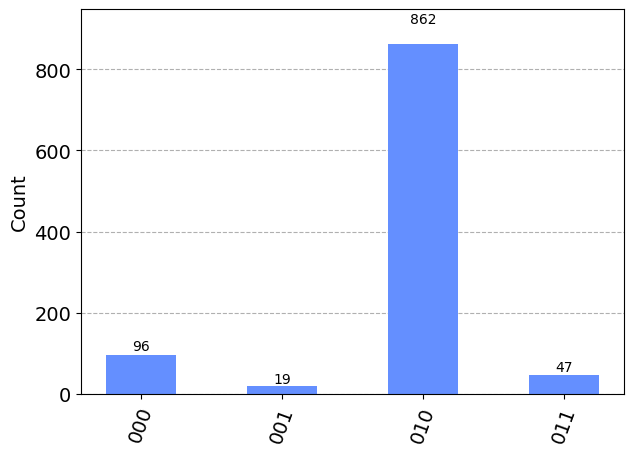

In [168]:
results = ibmq_job.result()
answer = results.get_counts()

plot_histogram(answer)